# Floating Array Design Project, Deep Case, Humboldt


In [1]:
from copy import deepcopy
from time import perf_counter
from pathlib import Path

import numpy as np
import pandas as pd

from waves import Project
from waves.utilities import load_yaml

# Update core Pandas display settings
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
metrics_configuration = {
    "# Turbines": {"metric": "n_turbines"},
    "Turbine Rating (MW)": {"metric": "turbine_rating"},
    "Project Capacity (MW)": {
        "metric": "capacity",
        "kwargs": {"units": "mw"}
    },
    "# OSS": {"metric": "n_substations"},
    "Total Export Cable Length (km)": {"metric": "export_system_total_cable_length"},
    "Total Array Cable Length (km)": {"metric": "array_system_total_cable_length"},
    "CapEx ($)": {"metric": "capex"},
    "CapEx per kW ($/kW)": {
        "metric": "capex",
        "kwargs": {"per_capacity": "kw"}
    },
    "OpEx ($)": {"metric": "opex"},
    "OpEx per kW ($/kW)": {"metric": "opex", "kwargs": {"per_capacity": "kw"}},
    "AEP (MWh)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "aep": True}
    },
    "AEP per kW (MWh/kW)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "per_capacity": "kw", "aep": True}
    },
    "Net Capacity Factor With All Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net"}
    },
    "Gross Capacity Factor (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "gross"}
    },
    "Energy Availability (%)": {
        "metric": "availability",
        "kwargs": {"which": "energy"}
    },
    "LCOE ($/MWh)": {"metric": "lcoe"},
}


# Define the final order of the metrics in the resulting dataframes
metrics_order = [
    "# Turbines",
    "Turbine Rating (MW)",
    "Project Capacity (MW)",
    "# OSS",
    "Total Export Cable Length (km)",
    "Total Array Cable Length (km)",
    "FCR (%)",
    "Offtake Price ($/MWh)",
    "CapEx ($)",
    "CapEx per kW ($/kW)",
    "OpEx ($)",
    "OpEx per kW ($/kW)",
    "Annual OpEx per kW ($/kW)",
    "Energy Availability (%)",
    "Gross Capacity Factor (%)",
    "Net Capacity Factor With All Losses (%)",
    "AEP (MWh)",
    "AEP per kW (MWh/kW)",
    "LCOE ($/MWh)",
    "Potential AEP from WOMBAT (kWh)",
    "Production AEP from WOMBAT (kWh)",
]

capex_order = [
    "Array System",
    "Export System",
    "Offshore Substation",
    "Substructure",
    "Scour Protection",
    "Mooring System",
    "Turbine",
    "Array System Installation",
    "Export System Installation",
    "Offshore Substation Installation",
    "Substructure Installation",
    "Scour Protection Installation",
    "Mooring System Installation",
    "Turbine Installation",
    "Soft",
    "Project",
]

In [3]:
def run_waves(project_floating):
    start2 = perf_counter()
    project_floating.run(full_wind_rose=False)
    project_floating.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
    end2 = perf_counter()
    
    print("-" * 29)  # separate our timing from the ORBIT and FLORIS run-time warnings
    print(f"Floating run time: {end2 - start2:,.2f} seconds")

    return project_floating

def average_and_save(dfs, filename, index_cols=None):
    df_concat = pd.concat(dfs)
    if index_cols:
        df_avg = df_concat.groupby(index_cols).mean()
    else:
        df_avg = df_concat.groupby(level=0).mean()
    df_avg.to_csv(filename)
    print(f"Saved: {filename}")

In [4]:
NUM_RUNS = 1
rng = np.random.default_rng(seed=834)

# Containers for each metric
capex_dfs = []
opex_dfs = []
charter_days_dfs = []
mobilization_dfs = []
delay_dfs = []
failure_cost_dfs = []
equipment_cost_dfs = []
report_dfs = []
losses_dfs = []

library_path = Path("../library/IEA_49_Deep_Case_Report/")
config_floating = load_yaml(library_path / "project/config", "base_floating_deep.yaml")
config_floating["floris_config"] = load_yaml(library_path / "project/config", config_floating["floris_config"])
config_floating["floris_config"]["farm"]["turbine_library_path"] = library_path / "turbines"
config_floating.update({"library_path": library_path})

config_wombat = load_yaml(library_path / "project/config", config_floating["wombat_config"])

for i in range(NUM_RUNS):
    print(f"\nRun {i + 1} of {NUM_RUNS}")

    # Load the project
    config = deepcopy(config_floating)
    config_wombat["random_generator"] = rng
    config_floating["wombat_config"] = config_wombat
    
    start = perf_counter()
    project_floating = Project.from_dict(config_floating)
    end = perf_counter()
    print(f"Floating loading time: {end - start:,.2f} seconds")

    # Run simulation
    project_floating = run_waves(project_floating)

    # Load key objects
    ev = project_floating.wombat.metrics.events
    years = project_floating.wombat.env.simulation_years
    metrics = project_floating.wombat.metrics
    materials = metrics.component_costs("project", by_category=True, by_task=True, by_action=False)
    avg_materials = materials[["materials_cost"]] / years

    # 0. CapEx Breakdown
    df_capex_floating = pd.DataFrame(
        project_floating.orbit.capex_detailed_soft_capex_breakdown.items(),
        columns=["Component", "CapEx ($) - Floating"]
    )
    df_capex_floating["CapEx ($/kW) - Floating"] = (
        df_capex_floating["CapEx ($) - Floating"] / project_floating.capacity("kw")
    )

    # Extract the onshore substation cost
    onshore_substation_cost = (
        project_floating.orbit.phases["ElectricalDesign"]
        .detailed_output["export_system"]["onshore_substation_costs"]
    )
    onshore_substation_cost_per_kw = onshore_substation_cost / project_floating.capacity("kw")

    # Append onshore substation as a row
    df_capex_floating.loc[len(df_capex_floating)] = [
        "Onshore Substation",
        onshore_substation_cost,
        onshore_substation_cost_per_kw
    ]

    # Set index for consistent merging
    df_capex_floating.set_index("Component", inplace=True)
    capex_dfs.append(df_capex_floating)
    
    # 1. Annual OpEx
    opex_df = metrics.opex(frequency='annual', by_category=True)
    opex_dfs.append(opex_df)

    # 2. Average Charter Days
    average_charter_days = []
    for name, vessel in project_floating.wombat.service_equipment.items():
        if vessel.settings.onsite or "TOW" in [el.value for el in vessel.settings.capability]:
            continue
        mobilizations = ev.loc[
            (ev.action.eq("mobilization") & ev.reason.str.contains("arrived on site"))
            & ev.agent.eq(name),
            ["agent", "env_time"]
        ]
        leaving = ev.loc[
            ev.action.eq("leaving site")
            & ev.agent.eq(name),
            ["agent", "env_time"]
        ]
        if mobilizations.shape[0] - leaving.shape[0] == 1:
            mobilizations = mobilizations.iloc[:-1]
        charter_days = (leaving.env_time.values - mobilizations.env_time.values) / 24
        average_charter_days.append([name, charter_days.mean()])
    charter_days_df = pd.DataFrame(average_charter_days, columns=["vessel", "average charter days"]).set_index("vessel")
    charter_days_dfs.append(charter_days_df)

    # 3. Mobilization Summary
    mobilization_summary = (
        ev.loc[ev.action.eq("mobilization") & ev.duration.gt(0), ["agent", "duration"]]
        .groupby("agent")
        .count()
        .rename(columns={"duration": "mobilizations"})
        .join(
            ev.loc[ev.action.eq("mobilization"), ["agent", "duration", "equipment_cost"]]
            .groupby("agent")
            .sum()
        )
    )
    mobilization_summary.duration /= 24
    mobilization_dfs.append(mobilization_summary)

    # 4. Delay Summary
    delay_summary = (
        ev.loc[
            ev.agent.isin(project_floating.wombat.service_equipment)
            & ev.duration.gt(0)
            & ev.action.eq("delay"),
            ["agent", "additional", "duration"]
        ]
        .replace({
            "no work requests submitted by start of shift": "no requests",
            "no work requests, waiting until the next shift": "no requests",
            "weather unsuitable to transfer crew": "weather delay",
            "work shift has ended; waiting for next shift to start": "end of shift",
            "insufficient time to complete travel before end of the shift": "end of shift",
            "will return next year": "end of charter",
        })
        .groupby(["agent", "additional"])
        .sum()
        .reset_index(drop=False)
        .set_index(["agent", "additional"])
        / 24
    )
    delay_dfs.append(delay_summary)

    # 5. Failure Costs
    timing = metrics.process_times()[["N"]].rename(columns={"N": "annual_occurrences"}) / years
    average_failures_costs = (
        avg_materials
        .rename(columns={"materials_cost": "annual_materials_cost"})
        .join(timing, how="outer")
        .fillna(0.0)
    )
    failure_cost_dfs.append(average_failures_costs)

    # 6. Equipment Cost Summary
    equipment_cost_df = metrics.equipment_costs(frequency="annual", by_equipment=True)
    equipment_cost_dfs.append(equipment_cost_df)

    # 7. Report DF
    project_name_floating = "FAD Deep Case - Floating"
    report_df_floating = project_floating.generate_report(metrics_configuration, project_name_floating).T
    n_years_floating = project_floating.operations_years
    additional_reporting = pd.DataFrame(
        [
            ["FCR (%)", project_floating.fixed_charge_rate],
            ["Offtake Price ($/MWh)", project_floating.offtake_price],
            [
                "Annual OpEx per kW ($/kW)",
                report_df_floating.loc["OpEx per kW ($/kW)", project_name_floating] / n_years_floating
            ],
            ["Potential AEP from WOMBAT (kWh)", project_floating.wombat.metrics.potential.windfarm.values.sum()/n_years_floating],
            ["Production AEP from WOMBAT (kWh)", project_floating.wombat.metrics.production.windfarm.values.sum()/n_years_floating],
        ],
        columns=["Project"] + report_df_floating.columns.tolist(),
    ).set_index("Project")

    report_df_floating = pd.concat((report_df_floating, additional_reporting), axis=0)
    report_df_floating.index.name = "Metrics"
    report_df_floating.loc[report_df_floating.index.str.contains("%")] *= 100
    report_dfs.append(report_df_floating)

    #8. Losses report
    report_df_losses = project_floating.loss_ratio(breakdown=True)
    losses_dfs.append(report_df_losses) 

# === Compute and save averages ===
average_and_save(capex_dfs, "IEA_49_Deep_Case_Report-results/deep_average_capex.csv", index_cols="Component")
average_and_save(opex_dfs, "IEA_49_Deep_Case_Report-results/deep_average_opex.csv")
average_and_save(charter_days_dfs, "IEA_49_Deep_Case_Report-results/deep_average_charter_days.csv", index_cols="vessel")
average_and_save(mobilization_dfs, "IEA_49_Deep_Case_Report-results/deep_average_mobilization_summary.csv", index_cols="agent")
average_and_save(delay_dfs, "IEA_49_Deep_Case_Report-results/deep_average_delay_summary.csv", index_cols=["agent", "additional"])
average_and_save(failure_cost_dfs, "IEA_49_Deep_Case_Report-results/deep_average_failures_costs.csv", index_cols=["subassembly", "task"])
average_and_save(equipment_cost_dfs, "IEA_49_Deep_Case_Report-results/deep_average_equipment_costs.csv")
average_and_save(report_dfs, "IEA_49_Deep_Case_Report-results/deep_average_report_df.csv", index_cols="Metrics")
average_and_save(losses_dfs, "IEA_49_Deep_Case_Report-results/deep_average_losses_report_df.csv")


Run 1 of 1
ORBIT library intialized at 'C:\iea49_TNO\WAVES\library\IEA_49_Deep_Case_Report'


Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: C:\Users\dmulash\.conda\envs\iea49_TNO\Lib\site-packages\ORBIT\phases\design\array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: C:\Users\dmulash\.conda\envs\iea49_TNO\Lib\site-packages\ORBIT\manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: C:\Users\dmulash\.conda\envs\iea49_TNO\Lib\site-packages\ORBIT\phases\design\_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 7.93 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: C:\Users\dmulash\.conda\envs\iea49_TNO\Lib\site-packages\ORBIT\phases\install\quayside_assembly_tow\moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: C:\Users\dmulash\.conda\envs\iea49_TNO\Lib\site-packages\floris\core\wake_deflection\gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 280.83 seconds
Saved: IEA_49_Deep_Case_Report-results/deep_average_capex.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_opex.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_charter_days.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_mobilization_summary.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_delay_summary.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_failures_costs.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_equipment_costs.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_report_df.csv
Saved: IEA_49_Deep_Case_Report-results/deep_average_losses_report_df.csv


In [5]:
pd.concat(failure_cost_dfs).reset_index().groupby(["subassembly", "task"]).sum() / years / NUM_RUNS

annual_materials_cost  \
subassembly          task                                                               
array cable          array cable major repair                                    0.00   
                     array cable replacement                                     0.00   
drive_train          main shaft major repair                                 1,260.00   
                     main shaft minor repair                                   732.50   
                     main shaft replacement                                  3,480.00   
electrical_system    power converter major repair                            7,805.00   
                     power converter minor repair                            1,750.00   
                     power converter replacement                            12,375.00   
                     power electrical system major repair                      175.00   
                     power electrical system major replacement                 750.00   
                     power electrical system minor repair                    1,067.50   
export cable         export cable subsea inspection                             12.50   
generator            annual turbine inspection                               5,025.00   
                     direct drive generator major repair                       932.10   
                     direct drive generator major replacement                5,321.25   
                     direct drive generator minor repair                     1,852.50   
hydraulic_system     major pitch system repair                               1,021.25   
                     major pitch system replacement                             35.00   
                     minor ballast pump repair                                  27.50   
                     minor pitch system repair                               1,328.75   
rotor_blades         blades major repair                                     2,069.28   
                     blades major replacement                                1,335.00   
                     blades minor repair                                     8,700.00   
supporting_structure anchor replacement                                     21,760.00   
                     buoyancy module replacement                            10,500.00   
                     major anchor repair                                     3,187.50   
                     marine growth removal                                     536.25   
                     mooring line major repair                               1,100.00   
                     mooring line replacement                                4,725.00   
                     structural annual inspection                            1,984.50   
                     structural subsea inspection                              791.25   
transformer          oss annual inspection                                      25.00   
                     oss minor repair                                           25.00   
yaw_system           yaw system major repair                                    45.00   
                     yaw system major replacement                               31.25   
                     yaw system minor repair                                   246.25   

                                                                annual_occurrences  
subassembly          task                                                           
array cable          array cable major repair                                 0.06  
                     array cable replacement                                  0.06  
drive_train          main shaft major repair                                  0.09  
                     main shaft minor repair                                  0.73  
                     main shaft replacement                                   0.01  
electrical_system    power converter major repair                             1.11  
 

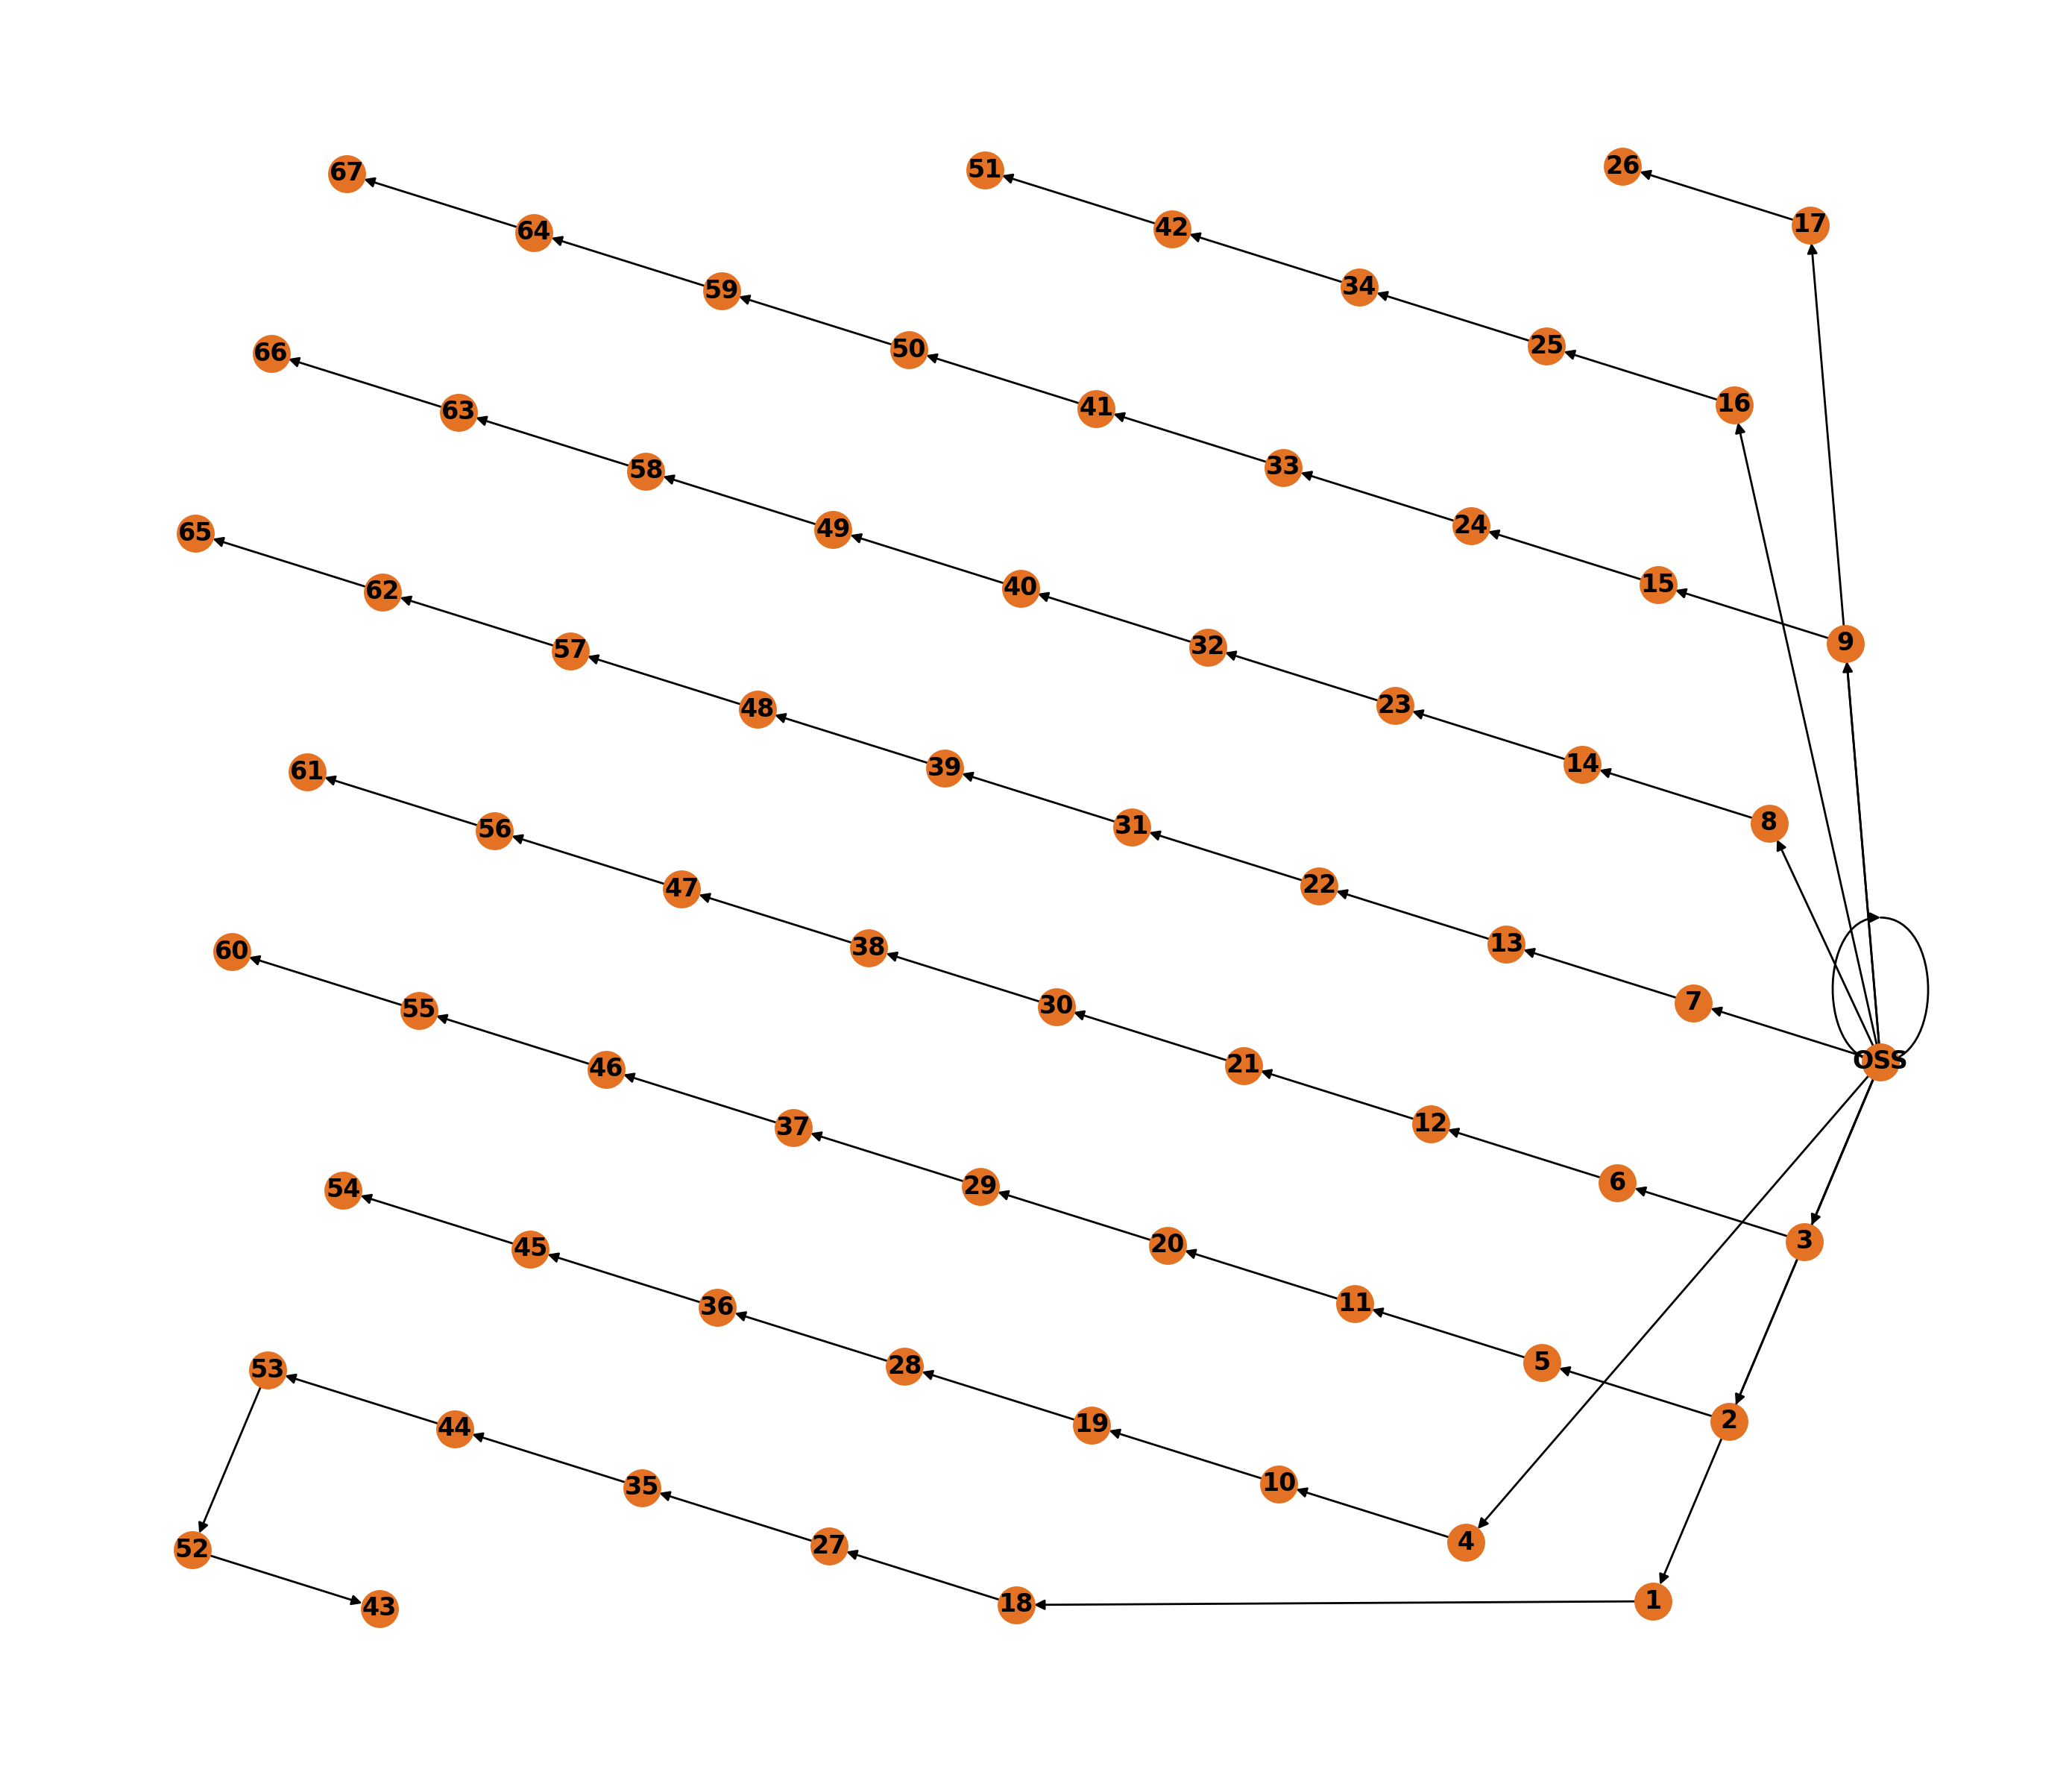

In [6]:
project_floating.plot_farm()